# **Vision industrielle** - Le traitement d'images dans le domaine médical
## Reconstruction d'une image 3D à partir de coupes 2D via l'algorithme du _Marching cubes_ et des techniques de traitement d'images
Par Robin MONTCHAMP, Tom SIMCOX, Kathleen EQUILBEC - Groupe 3 


Bibliothèques utilisées
- **numpy** : manipulation des données sous forme de tableaux
- **skimage** : traitement d'images
- **matplotlib.pyplot** : affichage 2D
- **visvis** : affichage 3D
- **glob** : récupération des chemins d'accès aux fichiers
- **pydicom** : utilisation des données médicales sous le format .dcm 

In [13]:
import numpy as np
import skimage
from matplotlib import pyplot as plt
import visvis as vv
import glob
from pydicom import dcmread

Les coupes 2D sont issues de scans CT (computed tomography) - technique mesurant l'absorption des rayons X par les tissus.

On utilisera le dataset suivant (à placer dans un fichier CT_files) : 
- https://www.kaggle.com/datasets/trainingdatapro/computed-tomography-ct-of-the-chest : scans de la poitrine et de l'abdomen

Chaque coupe est de taille 512x512 pixels et est disponible sous deux formats : .jpg et .dcm. Le format dicom (.dcm) est standard dans l'imagerie médicale, il contient de nombreuses informations sur le patient et sur le format de l'image. En particulier, dans notre cas, chaque pixel est codé sur 16 bits.

## Choix entre l'utilisation du scan de la tête ou de l'abdomen, et de l'utilisation du format dicom ou jpg

In [14]:
dicom = False #True : dicom ; False : .jpg
dossier = "CT_files"

## Récupération des données

In [15]:
options = [("abdomen/liver_formation/*", True, 4, 20)]

path, reverse, height, step = options[0] # name, reverse, heiht/width ratio, steps for plotting data
ext = ".dcm" if dicom else ".jpg" 


# Récupère le nom de tous les fichiers et les met dans l'ordre
files = glob.glob(dossier+"/"+path+ext)
separateur = files[0][-6] 

def sorting_func(file):
    return int(file.split(".")[0].split(separateur)[-1])

files = sorted(files, key = sorting_func, reverse=reverse)

# Récupère la taille des images (512x512)
if (dicom == True):
    shape = (dcmread(files[0]).pixel_array).shape[0]
else:
    shape = plt.imread(files[0]).shape[0]

# Lecture et stockage des images dans un np.array
images = np.zeros((len(files), shape, shape))
for i, file in enumerate(files):
    if (dicom == True):
        images[i] = dcmread(file).pixel_array + 2048
    else:
        images[i] = plt.imread(file)[:, :, 0] # images en noir et blanc, on n'a besoin que d'un seul canal

## Transformation d'histogramme
L'objectif est de conserver uniquement les zones les plus claires de l'image (celles qui absorbent le plus les rayons X). Pour cela, nous utilisons la méthode d'Otsu, qui permet de réaliser un seuillage automatique en à partir de l'histogramme de l'image. Cette méthode est appliquée une première fois pour séparer le fond de l'image du corps de la personne, puis une seconde fois pour isoler les zones les plus claires.

In [16]:
result = np.zeros((len(files), 512, 512), dtype=np.bool_)

for i, image in enumerate(images):
    #1er seuillage pour séparer le corps du fond
    thresh = skimage.filters.threshold_otsu(image[image!=0])
    binary = image > thresh

    THRESH = thresh
    IMAGE = image
    #2nd seuillage pour détecter les parties les plus blanches à l'intérieur du corps.
    #On ajuste quelques variables en fonction de si c'est un .jpg ou .dcm
    if (dicom == False):
        image = image*binary
        thresh = skimage.filters.threshold_otsu(image[image!=0])
        thresh += 30 #spécifique au dataset choisis, à modifier en fonction
        
    else:
        image = image*binary
        thresh = skimage.filters.threshold_otsu(image[image!=0])
        
        #3e seuillage parfois nécessaire
        if (thresh < 2050):
            binary = image > thresh
            image = image*binary
            thresh = skimage.filters.threshold_otsu(image[image!=0])

    result[i] = image > thresh

## Morphologie mathématique
On retire tous les objets plus petits qu'un certain seuil (assez élevé) pour retirer le bruit de l'image sans effacer les détails les plus fins.

In [17]:
result = skimage.morphology.remove_small_objects(result, 600, 2)

# Affichage 3D
La reconsitution d'une surface à partir de la matrice 3D est fait à l'aide de l'algorithme du "marching cubes". L'affichage 3D se fait dans une nouvelle fenêtre.

In [18]:
verts, faces, normals, values = skimage.measure.marching_cubes(result, spacing=(height, 1, 1), level=0)
vv.mesh(np.fliplr(verts), faces, normals, values, clim=[0,5*0]) # , colormap=vv.CM_HSV #permet d'ajouter une colormap
vv.use().Run()

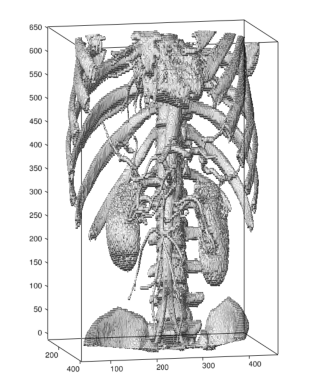

In [25]:
exemple = skimage.io.imread("screenshot.png")
plt.imshow(exemple)
plt.axis('off')
plt.show()

Temps total d'exécution : 11s

## Illustrations

### Le jeu de données

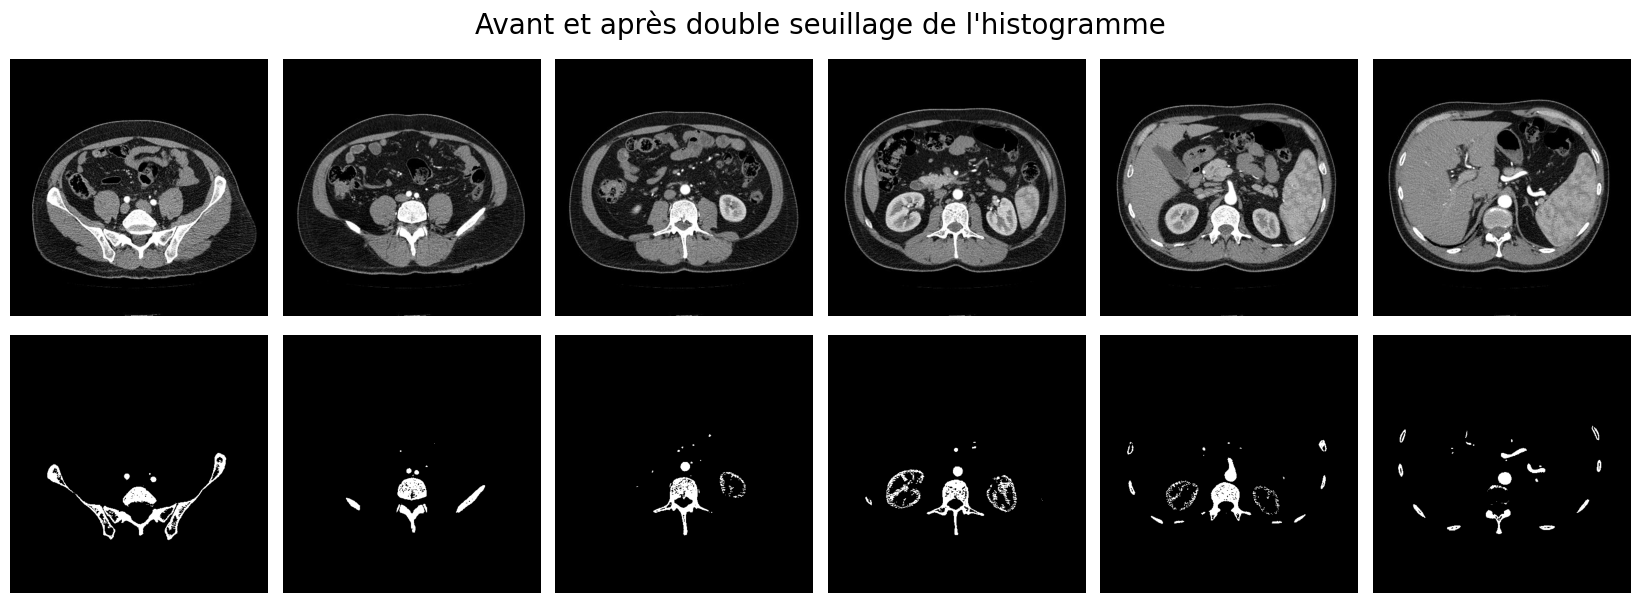

In [19]:
plt.figure(figsize=(16.5, 9))
for i in range(6):
    plt.subplot(3, 6, i+1)
    plt.imshow(images[i*step], cmap="grey")
    plt.gca().set_axis_off()

    plt.subplot(3, 6, i+1+6)
    plt.imshow(result[i*step], cmap="grey")
    plt.gca().set_axis_off()

plt.suptitle("Avant et après double seuillage de l'histogramme", fontsize=20)
plt.tight_layout()
plt.show()

### Exemple seuillage de l'histogramme

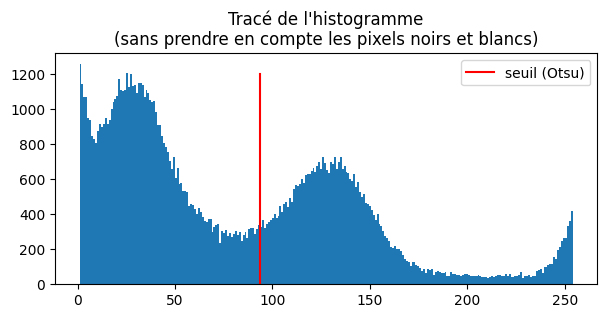

In [20]:
img = images[0][images[0]!=0]
thresh = skimage.filters.threshold_otsu(img)


plt.figure(figsize=(7, 3))
plt.hist(img[img != int(np.max(img))].ravel(), bins = int(np.max(img))-1)
#plt.plot(hist[1:-1])
plt.title("Tracé de l'histogramme\n(sans prendre en compte les pixels noirs et blancs)")

plt.plot([thresh]*2, [0, 1200], color='r', label='seuil (Otsu)')
plt.legend()
plt.show()